# Phase 2: Trajectory Prediction with Auxiliary Depth Estimation

# 🧭 Introduction


"""
Welcome to **Phase 2** of the DLAV Projec! 🚗💨

In this phase, you'll work with a more challenging dataset that includes:
- RGB **camera images**
- 3D trajectories
- Driving commands
- Ground-truth **depth maps**
- Ground-truth **semantic segmentation** labels

Your goal is still to predict the **future trajectory** of the self-driving car (SDC), but you now have more tools at your disposal! 🎯

Here, we provide an example where **depth estimation** is used as an auxiliary task to improve trajectory prediction.

However, you're **free to explore** other auxiliary tasks (e.g., using semantic labels), different loss functions, data augmentations, or better architectures! 💡

This notebook will walk you through loading the dataset, building a model, training with and without the auxiliary task, and visualizing results.
"""

In [ ]:
# Install gdown to handle Google Drive file download
!pip install -q gdown

import gdown
import zipfile

download_url = f"https://drive.google.com/uc?id=1YkGwaxBKNiYL2nq--cB6WMmYGzRmRKVr"
output_zip = "dlav_train.zip"
gdown.download(download_url, output_zip, quiet=False)  # Downloads the file to your drive
with zipfile.ZipFile(output_zip, 'r') as zip_ref:  # Extracts the downloaded zip file
    zip_ref.extractall(".")

download_url = "https://drive.google.com/uc?id=1wtmT_vH9mMUNOwrNOMFP6WFw6e8rbOdu"
output_zip = "dlav_val.zip"
gdown.download(download_url, output_zip, quiet=False)
with zipfile.ZipFile(output_zip, 'r') as zip_ref:
    zip_ref.extractall(".")

download_url = "https://drive.google.com/uc?id=1G9xGE7s-Ikvvc2-LZTUyuzhWAlNdLTLV"
output_zip = "dlav_test_public.zip"
gdown.download(download_url, output_zip, quiet=False)
with zipfile.ZipFile(output_zip, 'r') as zip_ref:
    zip_ref.extractall(".")

Downloading...
From (original): https://drive.google.com/uc?id=1YkGwaxBKNiYL2nq--cB6WMmYGzRmRKVr
From (redirected): https://drive.google.com/uc?id=1YkGwaxBKNiYL2nq--cB6WMmYGzRmRKVr&confirm=t&uuid=9c31f2d0-5d51-4600-850a-8f42c6a14aca
To: /content/dlav_train.zip
100%|██████████| 439M/439M [00:06<00:00, 65.0MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1wtmT_vH9mMUNOwrNOMFP6WFw6e8rbOdu
From (redirected): https://drive.google.com/uc?id=1wtmT_vH9mMUNOwrNOMFP6WFw6e8rbOdu&confirm=t&uuid=2d86e598-d074-4356-af03-5b80f1f12164
To: /content/dlav_val.zip
100%|██████████| 87.8M/87.8M [00:00<00:00, 95.0MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1G9xGE7s-Ikvvc2-LZTUyuzhWAlNdLTLV
From (redirected): https://drive.google.com/uc?id=1G9xGE7s-Ikvvc2-LZTUyuzhWAlNdLTLV&confirm=t&uuid=ab558f0d-c3f3-47a4-9dbe-fc905f96fc28
To: /content/dlav_test_public.zip
100%|██████████| 86.6M/86.6M [00:01<00:00, 46.1MB/s]


# 📂 The Dataset

We are now working with a richer dataset that includes not just images, commands and trajectories,
but also **depth maps** (and semantic segmentation labels, though unused in this example).

The data is stored in `.pkl` files and each file contains:
- `camera`: RGB image (shape: H x W x 3)
- `sdc_history_feature`: the past trajectory of the car
- `sdc_future_feature`: the future trajectory to predict
- `driving_command`: the current driving direction (`'left'`, `'right'`, `'forward'`)
- `depth`: ground truth depth map (shape: H x W x 1)

We'll define a `DrivingDataset` class to load and return these tensors in a format our model can work with.

**We have implemented data augmentation**, by adding the velocity and acceleration to the trajectory input. The dataset is also flipped horizontally half of the time to essentially double out dataset. And finally, we applied some minor diplacements, scaling and color changes to make the model more robust to more realistic conditions.

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision import transforms
import torch.optim as optim
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import random
# from dataset import DrivingDataset

class DrivingDataset(Dataset):
    def __init__(self, file_list, test=False):
        self.samples = file_list
        self.test = test

        self.transform = transforms.Compose([
            transforms.RandomAffine(degrees =0, translate=(0.05, 0.05), scale=(0.9, 1.1)),
            transforms.ColorJitter(brightness=0.2, contrast=0.3, saturation=0.3, hue=0.1),
        ])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        # Load pickle file
        with open(self.samples[idx], 'rb') as f:
            data = pickle.load(f)

        # Load image and normalize
        camera = torch.FloatTensor(data['camera']).permute(2, 0, 1) / 255.0
        if not self.test:
            camera = self.transform(camera)
            future = torch.FloatTensor(data['sdc_future_feature'])


        # Load other inputs
        history = torch.FloatTensor(data['sdc_history_feature'])
        command_str = data['driving_command']
        command = self.process_command(command_str)
        semantic = self.process_semantic(data['semantic_label'])
        depth = torch.FloatTensor(data['depth']).permute(2, 0, 1)

        # Apply horizontal flip with 50% chance
        if not self.test and random.random() < 0.5:
            camera = torch.flip(camera, dims=[2])  # Horizontal flip
            depth = torch.flip(depth, dims=[2])
            semantic = torch.flip(semantic, dims=[2])
            history = self.horizontal_flip_trajectory(history)
            future = self.horizontal_flip_trajectory(future)
            command = self.flip_command(command_str)

        # Add small Gaussian noise to trajectories
        if not self.test:
            history += torch.randn_like(history) * 0.01
            future += torch.randn_like(future) * 0.01

        history_aug = torch.zeros((21, 9), dtype=torch.float32)
        history_aug[:, 0:3] = history
        vel = history[1:] - history[:-1]            # shape [20, 3]
        history_aug[1:, 3:6] = vel                  # zero velocity for t=0
        acc = vel[1:] - vel[:-1]                    # shape [19, 3]
        history_aug[2:, 6:9] = acc

        # Return dictionary
        if not self.test:
          return {
            'camera': camera,
            'history': history_aug,
            'future': future,
            'command': command,
            'semantic': semantic,
            'depth': depth
          }
        else:
          return {
            'camera': camera,
            'history': history_aug,
            'command': command,
          }

    def process_semantic(self, label):
        num_classes = 15
        semantic_map = torch.zeros((num_classes, label.shape[0], label.shape[1]), dtype=torch.float32)
        for class_id in range(num_classes):
            semantic_map[class_id] = (torch.from_numpy(label) == class_id).float()
        lane_line_class = 12
        semantic_map[lane_line_class] *= 2.0
        return semantic_map

    def process_command(self, cmd_str):
        cmd_map = {'forward': [1, 0, 0], 'left': [0, 1, 0], 'right': [0, 0, 1]}
        return torch.tensor(cmd_map[cmd_str], dtype=torch.float32)

    def flip_command(self, cmd_str):
        if cmd_str == 'left':
            return self.process_command('right')
        elif cmd_str == 'right':
            return self.process_command('left')
        else:
            return self.process_command('forward')

    def horizontal_flip_trajectory(self, trajectory):
        # create a copy of the trajectory
        flipped = trajectory.clone()
        flipped[:,1] = -flipped[:, 1]
        return flipped


Visualize the dataset

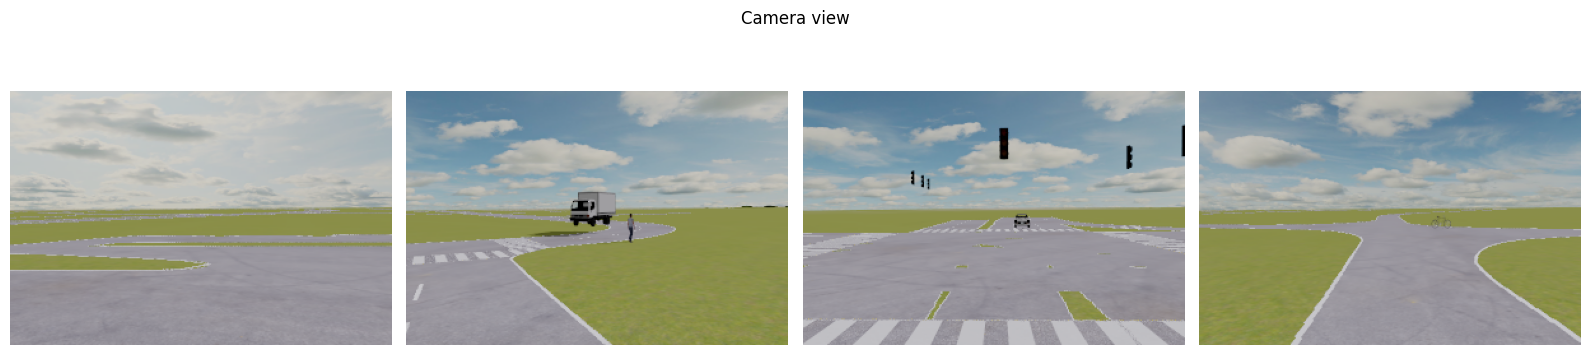

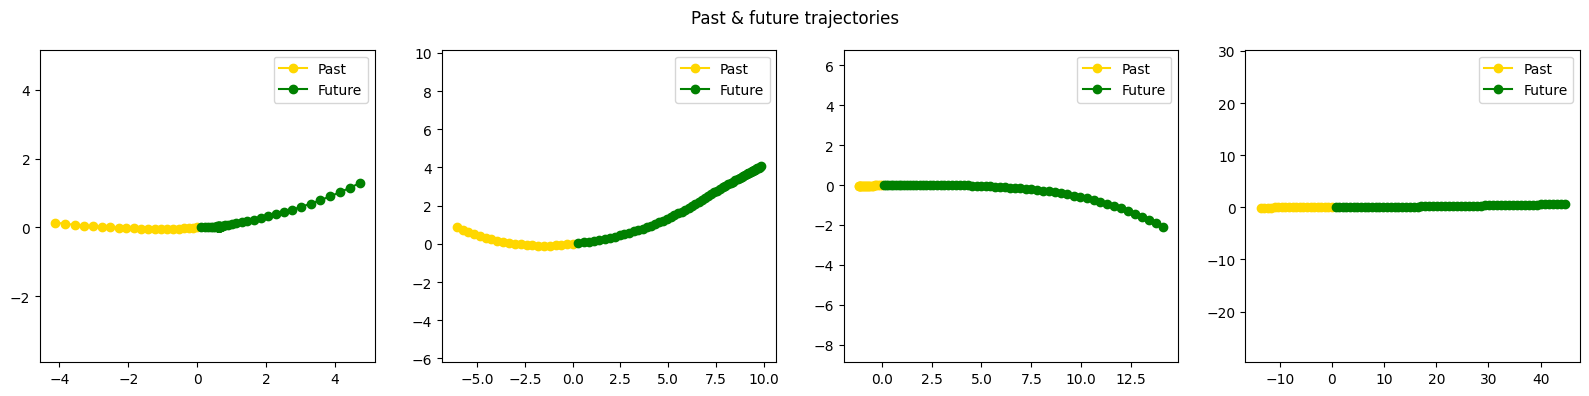

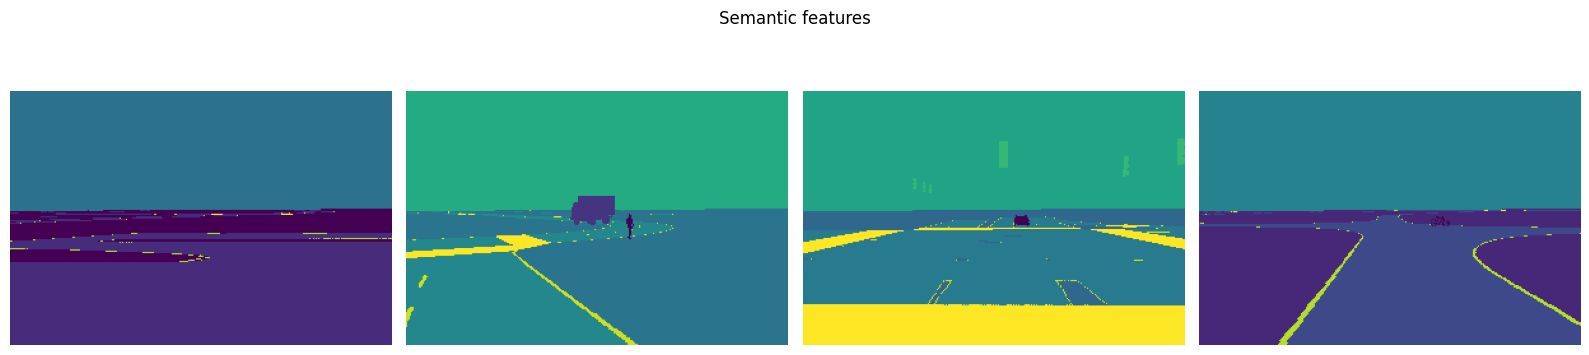

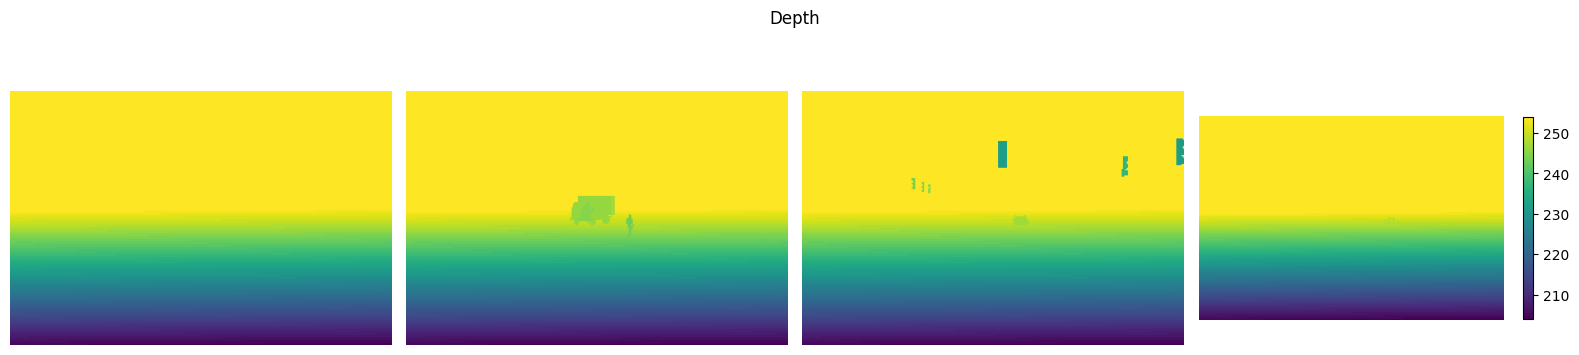

In [ ]:
k = 4
# load the data
data = []
for i in random.choices(np.arange(1000), k=k):
    with open(f"train/{i}.pkl", "rb") as f:
        data.append(pickle.load(f))

# plot the camera view of current step for the k examples
fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
for i in range(k):
    axis[i].imshow(data[i]["camera"])
    axis[i].axis("off")
plt.suptitle("Camera view")
plt.tight_layout()
plt.show()

# plot the past and future trajectory of the vehicle
fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
for i in range(k):
    axis[i].plot(data[i]["sdc_history_feature"][:, 0], data[i]["sdc_history_feature"][:, 1], "o-", color="gold", label="Past")
    axis[i].plot(data[i]["sdc_future_feature"][:, 0], data[i]["sdc_future_feature"][:, 1], "o-", color="green", label="Future")
    axis[i].legend()
    axis[i].axis("equal")
plt.suptitle("Past & future trajectories")
plt.tight_layout()
plt.show()

fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
for i in range(k):
    axis[i].imshow(data[i]["semantic_label"])
    axis[i].axis("off")
plt.suptitle("Semantic features")
plt.tight_layout()
plt.show()


fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
ims = []
for i in range(k):
    im = axis[i].imshow(data[i]["depth"])
    axis[i].axis("off")
    ims.append(im)

plt.suptitle("Depth")
plt.tight_layout()
fig.colorbar(ims[-1], shrink=0.6)
plt.tight_layout()
plt.show()

In [ ]:
class Logger:
    def __init__(self):
        # Placeholder for potential future configs (e.g., log_dir, wandb_enabled, etc.)
        self.train_loss = []
        self.ADE = []
        self.FDE = []
        self.MSE = []
        self.seg_loss = []
        self.depth_loss = []

    def log(self, step=None, **metrics):
        """
        Logs the given metrics.

        Args:
            step (int, optional): The current step or epoch. Useful for tracking.
            **metrics: Arbitrary keyword arguments representing metric names and values.
        """
        prefix = f"[Step {step}] " if step is not None else ""
        metric_str = " | ".join(f"{k}: {v}" for k, v in metrics.items())
        for k, v in metrics.items():
            if k == "train_loss":
                self.train_loss.append(v)
            elif k == "ADE":
                self.ADE.append(v)
            elif k == "FDE":
                self.FDE.append(v)
            elif k == "MSE":
                self.MSE.append(v)
            elif k == "seg_loss":
                self.seg_loss.append(v)
            elif k == "depth_loss":
                self.depth_loss.append(v)


## 🧠 The Model: Trajectory + Depth Prediction

We've extended our trajectory prediction model to optionally include a **depth estimation decoder**.

Why?
- Predicting depth helps the model **learn richer visual features** from the camera input.
- This acts as a form of **multi-task learning**, where learning to estimate depth reinforces scene understanding, ultimately leading to better trajectory predictions.
- This can be especially useful in complex environments with occlusions or sharp turns.

The model has:
- A CNN backbone to extract features from the image
- An MLP to process historical trajectory features
- A trajectory decoder to predict future coordinates
- (Optionally) A depth decoder to predict dense depth maps

We have extended that by adding :
- Pretrained ResNet50 or mobilenet_v3_small for feature extraction
- Deeper decoders to have more depth for learning

This auxiliary task is enabled by setting `use_depth_aux=True`.

In [ ]:
# class DrivingPlannerEnhanced3(nn.Module):
#     def __init__(self, use_depth_aux=False, use_segmentation_aux=False):
#         super().__init__()
#         self.use_depth_aux = use_depth_aux
#         self.use_segmentation_aux = use_segmentation_aux

#         ###########################
#         # 1 : Pretrained ResNet18
#         ###########################
#         backbone = models.resnet18(weights='DEFAULT')
#         self.resnet_backbone = nn.Sequential(*list(backbone.children())[:-2])        # Remove FC layer and pooling

#         # Freeze all except the last few layers
#         for param in list(self.resnet_backbone.parameters())[:-8]:
#             param.requires_grad = False
#         # self.backbone_out_channels = 1000

#         # Replace the last conv layer with a 1x1 conv layer
#         self.cnn_backbone = nn.Sequential(
#             nn.Conv2d(512, 128, kernel_size=1),
#             nn.BatchNorm2d(128),
#             nn.ReLU(),
#             nn.Conv2d(128, 32, kernel_size=1),
#             nn.BatchNorm2d(32),
#             nn.ReLU(),
#             nn.AdaptiveAvgPool2d((8, 8)),
#             nn.Dropout(0.3)  # Preventing Overfitting
#         )

#         self.cnn_flatten = nn.Flatten()

#         #############################
#         # 2 : Trajectory history & Command Encoder
#         #############################
#         self.history_encoder = nn.Sequential(
#             nn.Linear(21 * 3, 128),
#             nn.ReLU()
#         )

#         self.command_embedding = nn.Embedding(3, 32)

#         ###############################
#         # 3 : Input Fusion Transformer
#         ###############################
#         self.input_fusion_transformer = InputFusionTransformer(
#             img_dim=32*8*8,
#             com_dim=32,
#             hist_dim=128,
#         )

#         in_token_dim = self.input_fusion_transformer.in_token_dim

#         ################################
#         # 4 : Decoders for Future Trajectory, Depth, and Segmentation
#         ################################
#         self.trajectory_decoder = nn.Sequential(
#             nn.Linear(in_token_dim, 512),
#             nn.BatchNorm1d(512),    # Another batch normalization
#             nn.ReLU(),
#             nn.Dropout(0.2),        # Slightly reduced dropout
#             nn.Linear(512, 256),    # Another intermediate layer
#             nn.ReLU(),
#             nn.Linear(256, 60 * 3)  # Output layer remains the same
#         )

#         # Enhanced Depth Decoder (if used)
#         if self.use_depth_aux:
#             self.depth_decoder = nn.Sequential(
#                 nn.ConvTranspose2d(32, 128, kernel_size=3, stride=1, padding=1),  # Same size convolution
#                 nn.BatchNorm2d(128),  # Add batch normalization
#                 nn.ReLU(),
#                 nn.ConvTranspose2d(128, 96, kernel_size=4, stride=2, padding=1),  # Upsampling with more filters
#                 nn.BatchNorm2d(96),   # Add batch normalization
#                 nn.ReLU(),
#                 nn.ConvTranspose2d(96, 64, kernel_size=3, stride=1, padding=1),   # Additional layer
#                 nn.BatchNorm2d(64),   # Add batch normalization
#                 nn.ReLU(),
#                 nn.Conv2d(64, 1, kernel_size=3, padding=1),   # Output layer
#                 nn.Upsample(size=(200, 300), mode='bilinear', align_corners=False)  # Same final upsampling
#             )

#         # Enhanced Segmentation Decoder (if used)
#         if self.use_segmentation_aux:
#             self.segmentation_decoder = nn.Sequential(
#                 nn.ConvTranspose2d(32, 128, kernel_size=3, stride=1, padding=1),  # Same size convolution
#                 nn.BatchNorm2d(128),  # Add batch normalization
#                 nn.ReLU(),
#                 nn.ConvTranspose2d(128, 96, kernel_size=4, stride=2, padding=1),  # Upsampling with more filters
#                 nn.BatchNorm2d(96),   # Add batch normalization
#                 nn.ReLU(),
#                 nn.ConvTranspose2d(96, 64, kernel_size=3, stride=1, padding=1),   # Additional layer
#                 nn.BatchNorm2d(64),   # Add batch normalization
#                 nn.ReLU(),
#                 nn.Conv2d(64,63, kernel_size=3, padding=1),  # Output layer
#                 nn.Upsample(size=(200, 300), mode='bilinear', align_corners=False)  # Same final upsampling
#             )

#     def forward(self, camera, history, command):

#         img_feat = self.resnet_backbone(self.normalize_camera(camera))           # [32, 2048, 7, 10] previously [32, 128, 8, 8]
#         # print(img_feat.shape)
#         img_feat = self.cnn_backbone(img_feat)  # [32, 32, 8, 8]
#         # print(img_feat.shape)

#         img_feat_flat = self.cnn_flatten(img_feat)
#         # print("Flattened image feature shape:", img_feat_flat.shape)
#         hist_feat = self.history_encoder(history.view(history.size(0), -1))
#         command_label = torch.argmax(command, dim=1)
#         cmd_feat = self.command_embedding(command_label)

#         fused_feat = self.input_fusion_transformer(img_feat_flat, cmd_feat, hist_feat)
#         # print("Fused features :",fused_feat.shape)

#         future = self.trajectory_decoder(fused_feat)
#         future = future.view(-1, 60, 3)
#         # print("Traj :",future.shape)


#         # Optional depth map prediction
#         depth_out = None
#         if self.use_depth_aux:
#             depth_out = self.depth_decoder(img_feat.detach())

#         # Optional segmentation map prediction
#         segmentation_out = None
#         if self.use_segmentation_aux:
#             segmentation_out = self.segmentation_decoder(img_feat.detach())

#         return future, depth_out, segmentation_out

#     def normalize_camera(self, img):
#         # Normalized by ImageNet mean standard deviation
#         mean = torch.tensor([0.485, 0.456, 0.406], device=img.device).view(1, 3, 1, 1)
#         std = torch.tensor([0.229, 0.224, 0.225], device=img.device).view(1, 3, 1, 1)
#         return (img - mean) / std

# class InputFusionTransformer(nn.Module):
#     def __init__(self, img_dim, com_dim, hist_dim, depth = 2, heads = 8, dropout = 0.1, dim_feedforward=256):
#         super().__init__()
#         self.img_dim = img_dim
#         self.com_dim = com_dim
#         self.hist_dim = hist_dim
#         # self.fus_dim = fusion_dim

#         self.img_processing = nn.Sequential(
#             nn.Linear(img_dim, 512),
#             nn.LayerNorm(512),
#             nn.ReLU(),
#             nn.Linear(512, 256),
#             nn.LayerNorm(256),
#             nn.ReLU(),
#             nn.Dropout(dropout)
#         )

#         self.com_processing = nn.Sequential(
#             nn.Linear(com_dim, com_dim),
#             nn.LayerNorm(com_dim),
#             nn.ReLU(),
#             nn.Dropout(dropout)
#         )
#         self.hist_processing = nn.Sequential(
#             nn.Linear(hist_dim, hist_dim),
#             nn.LayerNorm(hist_dim),
#             nn.ReLU(),
#             nn.Dropout(dropout)
#         )

#         self.in_token_dim = hist_dim+com_dim+256

#         self.transformer = nn.TransformerEncoder(
#             nn.TransformerEncoderLayer(
#                 d_model=self.in_token_dim,
#                 nhead=heads,
#                 dim_feedforward=dim_feedforward,
#                 dropout=dropout,
#                 batch_first=True
#             ),
#             num_layers=depth
#         )
#         # Positional embeddings for the tokens
#         self.pos_embedding = nn.Parameter(torch.randn(1, self.in_token_dim))  # 3 tokens: camera, trajectory, command

#     def forward(self, camera, command, history):
#         # print("Cam :",camera.shape, ", command :",command.shape, ", hist :",history.shape)
#         # Cam : torch.Size([32, 8192]) , command : torch.Size([32, 32]) , hist : torch.Size([32, 128])
#         # print("Cam :",camera.shape, ", command :",command.shape, ", hist :",history.shape)
#         cam_feat = self.img_processing(camera)
#         com_feat = self.com_processing(command)
#         hist_feat = self.hist_processing(history)

#         # Stack features - each is [batch_size, dim]
#         features = torch.cat([cam_feat, com_feat, hist_feat], dim=1)
#         # features shape: [batch_size, 3, dim]

#         # Add positional embeddings
#         features = features + self.pos_embedding

#         # Pass through transformer
#         features = self.transformer(features)

#         return features


In [ ]:
class DrivingPlanner(nn.Module):
    def __init__(self, use_depth_aux=False):
        super().__init__()
        self.use_depth_aux = use_depth_aux


        self.pretrained_CNN = self._get_pretrained_backbone()
        backbone_output_dim = 576       # mobilenet_v3_small
        # backbone_output_dim = 2048         # resnet50


        CNN_out_dim = 128
        self.cnn_backbone = nn.Sequential(
            nn.Conv2d(backbone_output_dim, CNN_out_dim*4,  kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(CNN_out_dim*4),
            nn.ReLU(),
            nn.Conv2d(CNN_out_dim*4, CNN_out_dim,  kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(CNN_out_dim),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((8, 8)),
            nn.Dropout(0.3)  # Preventing Overfitting
        )

        self.cnn_flatten = nn.Flatten()

        #############################
        # 2 : Trajectory history & Command Encoder
        #############################
        hist_enc_out_dim = 128
        self.history_encoder = nn.Sequential(
            nn.Linear(21 * 9, hist_enc_out_dim),
            nn.ReLU()
        )

        com_emb_out_dim = 32
        self.command_embedding = nn.Embedding(3, com_emb_out_dim)


        stack_output_dim = CNN_out_dim*8*8 + hist_enc_out_dim + com_emb_out_dim

        ################################
        # 4 : Decoders for Future Trajectory, Depth, and Segmentation
        ################################
        self.trajectory_decoder = nn.Sequential(
            nn.Linear(stack_output_dim, 1028),
            nn.BatchNorm1d(1028),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(1028, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(512, 256),
            nn.ReLU(),

            nn.Linear(256, 60 * 3)  # Output layer remains the same
        )

        # Enhanced Depth Decoder (if used)
        if self.use_depth_aux:
            self.depth_decoder = nn.Sequential(
                nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),  # (7,10) → (14,20)
                nn.ConvTranspose2d(128, 128, kernel_size=3, stride=1, padding=1),  # Same size convolution
                nn.BatchNorm2d(128),
                nn.ReLU(),
                nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),  # (14,20) → (28,40)
                nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),   # Additional layer
                nn.BatchNorm2d(64),
                nn.ReLU(),
                nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),  # (28,40) → (56,80)
                nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1),   # Output layer
                nn.Upsample(size=(200, 300), mode='bilinear', align_corners=False)  # Same final upsampling
            )

    def forward(self, camera, history, command):
        ###############################
        # 1 : Camera Encoder
        ###############################
        img_post_effNet = self.pretrained_CNN(camera)                       # (B, 1792, 7, 10)
        img_post_CNN = self.cnn_backbone(img_post_effNet)                   # (B, 128, 7, 10)
        img_feat_flat = self.cnn_flatten(img_post_CNN)                      # (B, 128*7*10) = (B, 8960)

        ###############################
        # 2 : Trajectory history & Command Encoder
        ###############################
        hist_feat = self.history_encoder(history.view(history.size(0), -1)) # (B, 128)

        command_label = torch.argmax(command, dim=1)                        # (B, 32)
        cmd_feat = self.command_embedding(command_label)

        feat = torch.cat([img_feat_flat, hist_feat, cmd_feat], dim=-1)      # (B, 8960 + 128 + 32) => (B, 9120)
        future = self.trajectory_decoder(feat).view(-1, 60, 3)                              # (B, 60, 3)

        # Optional depth map prediction
        depth_out = None
        if self.use_depth_aux:
            depth_out = self.depth_decoder(img_post_CNN.detach())           # (B, 1, 200, 300)


        return future, depth_out

    def _get_pretrained_backbone(self):
        # Load with pretrained weights
        mobilenet = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.DEFAULT)

        # Remove classifier (last layer)
        backbone = nn.Sequential(*list(mobilenet.features))

        # Freeze
        trainable_layers = list(backbone.children())[-3:] # Only fine-tune last 3 blocks
        for param in backbone.parameters():
            param.requires_grad = False
        for layer in trainable_layers:
            for param in layer.parameters():
                param.requires_grad = True

        return backbone

    def _get_pretrained_backbone2(self):
        # Load ResNet50 with pretrained weights
        resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

        # Remove last FC and pooloing layers
        backbone = nn.Sequential(*list(resnet.children())[:-2])

        # Freeze
        for param in backbone.parameters():
            param.requires_grad = False
        for layer in list(backbone.children())[-3:]:  # Only fine-tune last 3 blocks
            for param in layer.parameters():
                param.requires_grad = True

        return backbone


## 🏋️ Training with Auxiliary Loss

The training loop is similar to Phase 1 — except now, if enabled, we also compute a loss on the predicted **depth map**.

We define:
- `trajectory_loss` as standard MSE between predicted and true future trajectory
- `depth_loss` as L1 loss between predicted and ground truth depth

We added :
- `loss_smooth` to penalize for sudden acceleration (jerk)
- `curve_loss` to encourage smooth trajectory curves
Total loss = `trajectory_loss + lambda * depth_loss`

This helps guide the model to learn better representations from visual input. The weight `lambda` is a hyperparameter you can tune!

In [ ]:

def train_one_epoch(model, train_loader, optimizer, device, lambda_depth=0.1, use_depth_aux=False):
    model.train()
    criterion = nn.SmoothL1Loss()  #
    train_loss = 0.0

    for batch in train_loader:
        cam, hist, fut, depth, command = [batch[k].to(device) for k in ['camera', 'history', 'future', 'depth', 'command']]
        optimizer.zero_grad()
        fut_pred, dep_pred = model(cam, hist, command)

        traj_loss = F.mse_loss(fut_pred, fut)
        loss_heading = criterion(fut_pred[..., 2], fut[..., 2])
        ade_loss = torch.norm(fut_pred[:, :, :2] - fut[:, :, :2], dim=2).mean(dim=1).sum()
        loss = traj_loss + 0.2 * loss_heading + 0.5 * ade_loss

        if use_depth_aux:
            loss += lambda_depth * F.l1_loss(dep_pred, depth)

        is_turning = (command[:,1] == 1) | (command[:,2] == 1)  # left or right
        weights = torch.where(is_turning, 1.5, 1.0).to(device)
        loss = (loss * weights).mean()

        # Acceleration smoothness loss
        vel = fut_pred[:, 1:] - fut_pred[:, :-1]
        acc = vel[:, 1:] - vel[:, :-1]
        jerk = acc[:, 1:] - acc[:, :-1]
        loss_smooth = jerk.norm(p=2, dim=2).mean()      # L2 norm of jerk
        loss += 0.05 * loss_smooth

        # curve smoothness loss
        curve = torch.atan2(torch.sin(fut_pred[:, 1:, 1] - fut_pred[:, :-1, 1]), torch.cos(fut_pred[:, 1:, 0] - fut_pred[:, :-1, 0]))
        curve_diff = curve[:, 1:] - curve[:, :-1]
        curve_loss = curve_diff.norm(p=2, dim=1).mean()  # L2 norm of curve difference
        loss += 0.05 * curve_loss


        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_loss = train_loss / len(train_loader)
    return avg_loss

def validate(model, val_loader, device, lambda_depth=0.1, use_depth_aux=False):
    model.eval()
    total_ade, total_fde, total_mse, total_depth_loss = 0.0, 0.0, 0.0, 0.0
    count = 0

    with torch.no_grad():
        for batch in val_loader:
            cam = batch['camera'].to(device)           # (batch, 3, H, W)
            # semantic = batch['semantic'].to(device)    # (batch, 15, H, W)
            hist = batch['history'].to(device)         # (batch, 21, 3)
            command = batch['command'].to(device)      # (batch, 3)
            fut = batch['future'].to(device)           # (batch, 60, 3)
            depth = batch['depth'].to(device)

            fut_pred, dep_pred = model(cam, hist, command)

            B, T, _ = fut.shape
            count += B

            ade = torch.norm(fut_pred[:, :, :2] - fut[:, :, :2], dim=2).mean(dim=1).sum()
            fde = torch.norm(fut_pred[:, -1, :2] - fut[:, -1, :2], dim=1).sum()
            mse = F.mse_loss(fut_pred, fut, reduction='sum')

            if use_depth_aux:
                total_depth_loss += lambda_depth * F.l1_loss(dep_pred, depth)

            total_ade += ade.item()
            total_fde += fde.item()
            total_mse += mse.item()


    ade_avg = total_ade / count
    fde_avg = total_fde / count
    mse_avg = total_mse / (count * T * 3)


    depth_loss_avg = total_depth_loss / count

    return ade_avg, fde_avg, mse_avg, depth_loss_avg

def train(model, train_loader, val_loader, optimizer, logger, num_epochs=50, lambda_depth=0.1, use_depth_aux=False):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    model = model.to(device)

    for epoch in range(num_epochs):
        train_loss = train_one_epoch(model, train_loader, optimizer, device, lambda_depth, use_depth_aux)
        ade, fde, mse, depth_loss = validate(model, val_loader, device, lambda_depth, use_depth_aux)

        logger.log(step=epoch, train_loss=train_loss, ADE=ade, FDE=fde, MSE=mse, depth_loss=depth_loss)
        print(f"Epoch {epoch+1}, Loss: {train_loss:.3f}, Validation - ADE: {ade:.3f}, FDE: {fde:.3f}, Traj MSE: {mse:.3f}, Depth Loss: {depth_loss:.3f}")



In [ ]:
train_data_dir = "train"
val_data_dir = "val"

train_files = [os.path.join(train_data_dir, f) for f in os.listdir(train_data_dir) if f.endswith('.pkl')]
val_files = [os.path.join(val_data_dir, f) for f in os.listdir(val_data_dir) if f.endswith('.pkl')]

train_dataset = DrivingDataset(train_files)
val_dataset = DrivingDataset(val_files)

train_loader = DataLoader(train_dataset, batch_size=32, num_workers=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, num_workers=2)


## 🔍 Let's Compare Two Settings

We'll now train and evaluate the model in **two modes**:

1. **Without auxiliary task** — the model only predicts the trajectory.
2. **With depth auxiliary task** — the model also predicts a depth map, which helps it learn better visual features.

By comparing the results (ADE, FDE, and Trajectory MSE), you'll see the benefit of multi-task learning in action! 🚀

In [ ]:
use_depth_aux=False
model_no_aux = DrivingPlanner(use_depth_aux=use_depth_aux)
optimizer = optim.Adam(model_no_aux.parameters(), lr=1e-3)
logger_no_aux = Logger()
train(model_no_aux, train_loader, val_loader, optimizer, logger_no_aux, num_epochs=1,use_depth_aux=use_depth_aux)

Using device: cuda
Epoch 1, Loss: 22.9186, Validation - ADE: 4.0099, FDE: 9.3770, Traj MSE: 12.251686
Epoch 2, Loss: 12.1647, Validation - ADE: 3.3641, FDE: 8.3131, Traj MSE: 9.574406
Epoch 3, Loss: 9.8522, Validation - ADE: 3.4812, FDE: 8.5076, Traj MSE: 9.062673
Epoch 4, Loss: 7.8995, Validation - ADE: 2.9848, FDE: 7.4598, Traj MSE: 7.337304
Epoch 5, Loss: 6.8192, Validation - ADE: 2.4812, FDE: 6.5501, Traj MSE: 5.998971
Epoch 6, Loss: 6.2871, Validation - ADE: 2.4374, FDE: 6.6189, Traj MSE: 5.879153
Epoch 7, Loss: 6.1018, Validation - ADE: 2.7324, FDE: 7.0414, Traj MSE: 6.175226
Epoch 8, Loss: 5.8419, Validation - ADE: 2.9170, FDE: 7.3691, Traj MSE: 6.510932
Epoch 9, Loss: 5.6277, Validation - ADE: 2.4065, FDE: 6.4122, Traj MSE: 5.614890
Epoch 10, Loss: 5.3516, Validation - ADE: 2.4830, FDE: 6.5718, Traj MSE: 5.395532


In [48]:
use_depth_aux=True
model_with_aux = DrivingPlanner(use_depth_aux=use_depth_aux)
optimizer = optim.Adam(model_with_aux.parameters(), lr=1e-3)
logger_aux = Logger()
train(model_with_aux, train_loader, val_loader, optimizer, logger_aux, num_epochs=50,use_depth_aux=use_depth_aux, lambda_depth=0.05)

Otherwise, load model.

In [ ]:
model_with_aux = DrivingPlanner(use_depth_aux=True)
optimizer = optim.Adam(model_with_aux.parameters(), lr=1e-3)
logger_aux = Logger()
model_with_aux.load_state_dict(torch.load("model_phase2.pth"))
model_with_aux.eval()

DrivingPlanner(
  (pretrained_CNN): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size

# Annexes

Example code to get metric plots from logger

In [43]:
# load logger data into logger
with open("logger_data_phase2.pkl", "rb") as f:
    logger_aux = pickle.load(f)

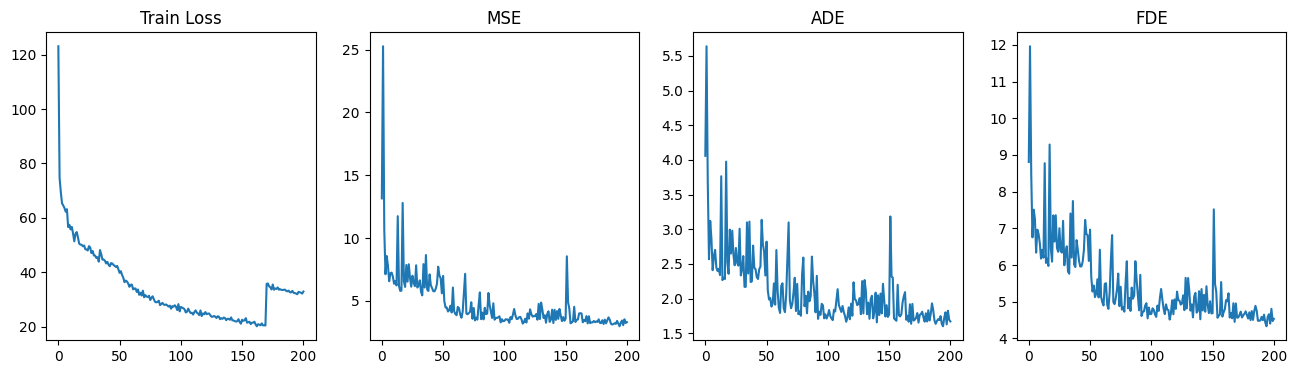

1.5995565366744995


In [44]:
# plot 4 losses in 4 plots
fig, axis = plt.subplots(1, 4, figsize=(16, 4))
axis[0].plot(logger_aux.train_loss)
axis[0].set_title("Train Loss")
axis[1].plot(logger_aux.MSE)
axis[1].set_title("MSE")
axis[2].plot(logger_aux.ADE)
axis[2].set_title("ADE")
axis[3].plot(logger_aux.FDE)
axis[3].set_title("FDE")

plt.show()
print(min(logger_aux.ADE))

Code to save model from colab

In [ ]:
torch.save(model_with_aux.state_dict(), "phase2_model_w_depth.pth")

## Uncomment the following lines to download the model file in Google Colab
# from google.colab import files
# files.download("phase2_model_w_depth.pth")

Get validation metrics

In [49]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ade, fde, mse, _ = validate(model_no_aux, val_loader, device)
# print(f"Validation results for model without depth auxiliary loss: ADE: {ade:.4f}, FDE: {fde:.4f}, Traj MSE: {mse:.4f}")

ade, fde, mse, depth_loss = validate(model_with_aux, val_loader, device, lambda_depth=0.05, use_depth_aux=True)
print(f"Validation results for model with depth auxiliary loss: ADE: {ade:.4f}, FDE: {fde:.4f}, Traj MSE: {mse:.4f}, depth loss (depth): {depth_loss:.4f}")

Validation results for model with depth auxiliary loss: ADE: 1.6843, FDE: 4.6160, Traj MSE: 3.3318, depth loss (depth): 0.0021


## 🔍 Final Visualization and Comparison

Now that we’ve trained two models — one **with** the depth auxiliary task and one **without** — let’s visualize and compare their predictions.

We’ll show:
1. The **camera image** from selected validation examples
2. The **past trajectory**, **ground-truth future**, and **predicted future** trajectory
3. The **predicted vs. ground-truth depth maps** (only for the model trained with the auxiliary task)

These visualizations help us understand:
- Does the predicted trajectory better match the future when the depth task is included?
- Is the predicted depth map reasonably accurate?

Let’s see the difference! 📈

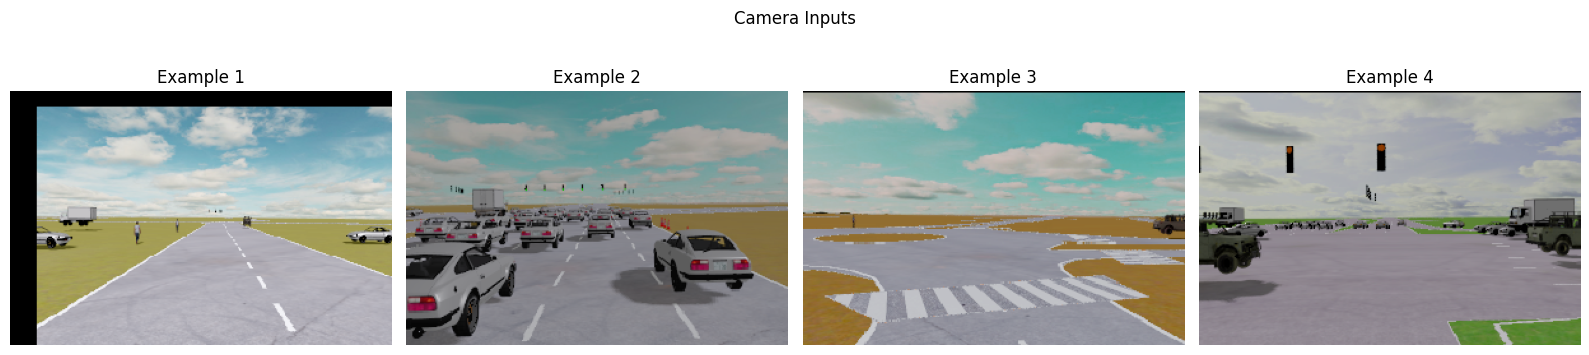

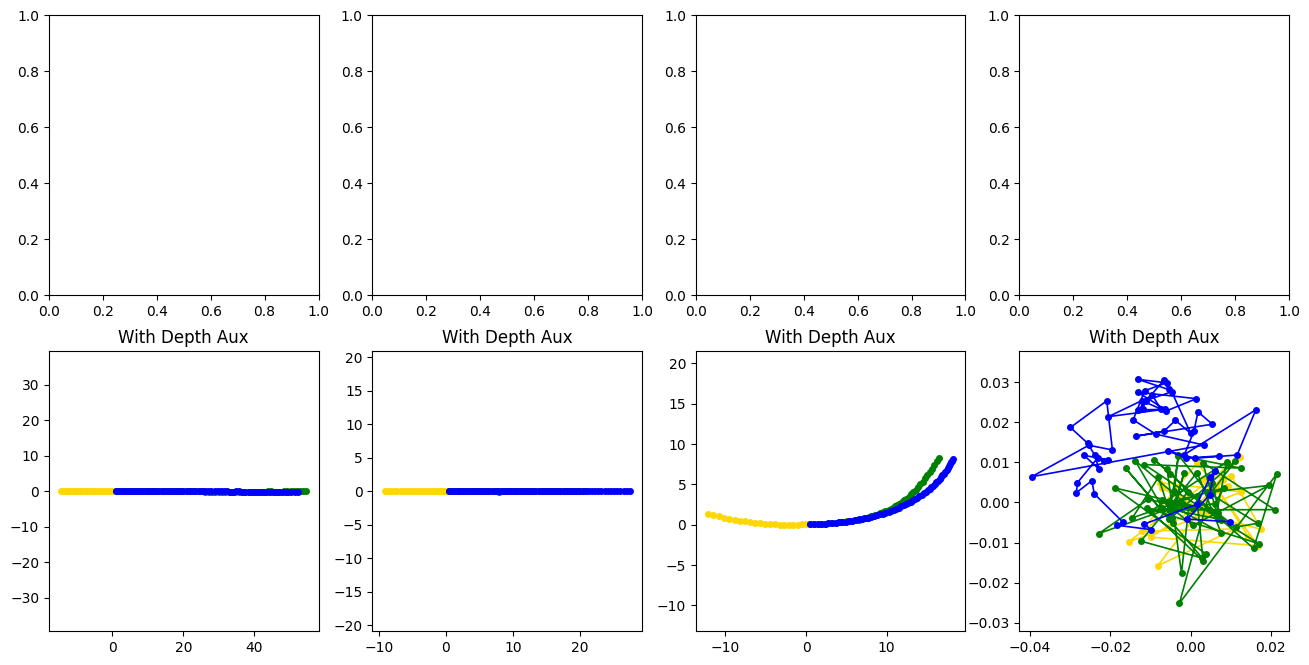

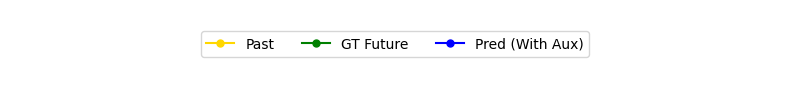

<Figure size 640x480 with 0 Axes>

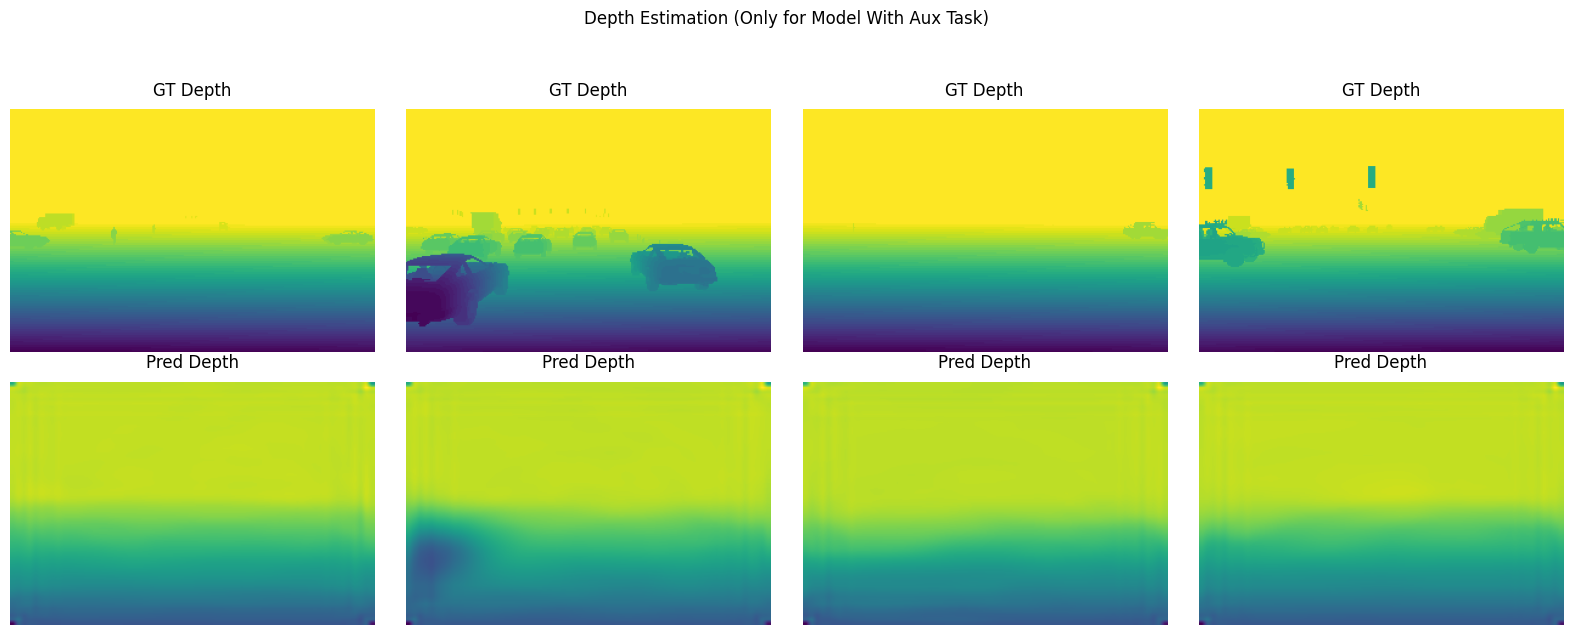

In [47]:
from codeop import CommandCompiler
import matplotlib.pyplot as plt
import random

random.seed(40)

def visualize_comparison(val_loader, model_no_aux, model_with_aux, device):
    # model_no_aux.eval()
    model_with_aux.eval()
    val_batch = next(iter(val_loader))

    camera = val_batch['camera'].to(device)
    history = val_batch['history'].to(device)
    future = val_batch['future'].to(device)
    depth = val_batch['depth'].to(device)
    command = val_batch['command'].to(device)

    with torch.no_grad():
        # pred_no_aux, _ = model_no_aux(camera, history, command)
        pred_with_aux, pred_depth = model_with_aux(camera, history, command)

    camera = camera.cpu().numpy()
    history = history.cpu().numpy()
    future = future.cpu().numpy()
    # pred_no_aux = pred_no_aux.cpu().numpy()
    pred_with_aux = pred_with_aux.cpu().numpy()
    depth = depth.cpu().numpy()
    pred_depth = pred_depth.cpu().numpy() if pred_depth is not None else None

    k = 4
    indices = random.choices(np.arange(len(camera)), k=k)

    # Show the input camera images
    fig, ax = plt.subplots(1, k, figsize=(4 * k, 4))
    for i, idx in enumerate(indices):
        ax[i].imshow(camera[idx].transpose(1, 2, 0))
        ax[i].set_title(f"Example {i+1}")
        ax[i].axis("off")
    plt.suptitle("Camera Inputs")
    plt.tight_layout()
    plt.show()

    # Compare predicted trajectories
    fig, ax = plt.subplots(2, k, figsize=(4 * k, 8))
    for i, idx in enumerate(indices):
        # Without aux
        # ax[0, i].plot(history[idx, :, 0], history[idx, :, 1], 'o-', label='Past', color='gold', markersize=4, linewidth=1.2)
        # ax[0, i].plot(future[idx, :, 0], future[idx, :, 1], 'o-', label='GT Future', color='green', markersize=4, linewidth=1.2)
        # # ax[0, i].plot(pred_no_aux[idx, :, 0], pred_no_aux[idx, :, 1], 'o-', label='Pred (No Aux)', color='red', markersize=4, linewidth=1.2)
        # ax[0, i].set_title("No Depth Aux")
        # ax[0, i].axis("equal")

        # With aux
        ax[1, i].plot(history[idx, :, 0], history[idx, :, 1], 'o-', label='Past', color='gold', markersize=4, linewidth=1.2)
        ax[1, i].plot(future[idx, :, 0], future[idx, :, 1], 'o-', label='GT Future', color='green', markersize=4, linewidth=1.2)
        ax[1, i].plot(pred_with_aux[idx, :, 0], pred_with_aux[idx, :, 1], 'o-', label='Pred (With Aux)', color='blue', markersize=4, linewidth=1.2)
        ax[1, i].set_title("With Depth Aux")
        ax[1, i].axis("equal")

    # Show full legend in a new figure
    fig_legend = plt.figure(figsize=(8, 1))
    legend_handles = [
        plt.Line2D([0], [0], color='gold', marker='o', linestyle='-', markersize=5, label='Past'),
        plt.Line2D([0], [0], color='green', marker='o', linestyle='-', markersize=5, label='GT Future'),
        # plt.Line2D([0], [0], color='red', marker='o', linestyle='-', markersize=5, label='Pred (No Aux)'),
        plt.Line2D([0], [0], color='blue', marker='o', linestyle='-', markersize=5, label='Pred (With Aux)')
    ]
    fig_legend.legend(handles=legend_handles, loc='center', ncol=4)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    plt.suptitle("Trajectory Prediction: Without vs With Depth Aux Task")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # Show predicted vs GT depth (only for bottom row)
    if pred_depth is not None:
        fig, ax = plt.subplots(2, k, figsize=(4 * k, 6))
        for i, idx in enumerate(indices):
            ax[0, i].imshow(depth[idx, 0, :, :], cmap='viridis')
            ax[0, i].set_title("GT Depth", pad=10)
            ax[0, i].axis("off")
            # increase vertical distance between rows

            ax[1, i].imshow(pred_depth[idx, 0, :, :], cmap='viridis')
            ax[1, i].set_title("Pred Depth", pad=10)
            ax[1, i].axis("off")

        plt.suptitle("Depth Estimation (Only for Model With Aux Task)", y=1.05)
        plt.subplots_adjust(hspace=0.4)
        plt.tight_layout()
        plt.show()


# 🔚 Call at the end after training both models
visualize_comparison(val_loader, 0, model_with_aux, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

Now we run our model on the test set once, to get the plan of our model and save it for submission. Notice that the ground truth plans are removed for the test set, so you can not calculate the ADE metric on the test set yourself, and need to submit it to the leader board. By running the last cell, you'll be able to see a csv file called submission_phase2.csv by clicking on the folder icon on the left. Download it and submit it to the leaderboard to get your score.

In [ ]:
with open(f"test_public/0.pkl", "rb") as f:
    data = pickle.load(f)
print(data.keys())
# Note the absence of sdc_future_feature

dict_keys(['camera', 'depth', 'driving_command', 'sdc_history_feature', 'semantic_label'])


## Create output file for Kaggle submission

In [ ]:
model_with_aux = DrivingPlanner(use_depth_aux=True)
optimizer = optim.Adam(model_with_aux.parameters(), lr=1e-3)
logger_aux = Logger()
model_with_aux.load_state_dict(torch.load("driving_planner_model_depth_effnetv3_mse200.pth"))
model_with_aux.to(device)
model_with_aux.eval()

test_data_dir = "test_public"
test_files = [os.path.join(test_data_dir, fn) for fn in sorted([f for f in os.listdir(test_data_dir) if f.endswith(".pkl")], key=lambda fn: int(os.path.splitext(fn)[0]))]
test_dataset = DrivingDataset(test_files, test=True)
test_loader = DataLoader(test_dataset, batch_size=250, num_workers=1)
model_with_aux.to(device)
model_with_aux.eval()
all_plans = []
with torch.no_grad():
    for batch in test_loader:
        camera = batch['camera'].to(device)
        history = batch['history'].to(device)
        command = batch['command'].to(device)

        pred_future, _ = model_with_aux(camera, history, command)
        all_plans.append(pred_future.cpu().numpy()[..., :2])
all_plans = np.concatenate(all_plans, axis=0)

# Now save the plans as a csv file
pred_xy = all_plans[..., :2]  # shape: (total_samples, T, 2)

# Flatten to (total_samples, T*2)
total_samples, T, D = pred_xy.shape
pred_xy_flat = pred_xy.reshape(total_samples, T * D)

# Build a DataFrame with an ID column
ids = np.arange(total_samples)
df_xy = pd.DataFrame(pred_xy_flat)
df_xy.insert(0, "id", ids)

# Column names: id, x_1, y_1, x_2, y_2, ..., x_T, y_T
new_col_names = ["id"]
for t in range(1, T + 1):
    new_col_names.append(f"x_{t}")
    new_col_names.append(f"y_{t}")
df_xy.columns = new_col_names

# Save to CSV
df_xy.to_csv("submission_phase2.csv", index=False)

print(f"Shape of df_xy: {df_xy.shape}")

Shape of df_xy: (1000, 121)
